In [375]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.constants import N_A
from scipy.optimize import fsolve
from matplotlib.colors import LogNorm

In [376]:
#Dimensional Parameters

rtot = 2.2e5
qon = 7e3
qoff = 5e-3
qon_e = 7e3
qoff_e = 5e-3

Target_cell_number = 1e5
well_size = 150e-6
sigma = well_size*N_A/Target_cell_number

therapeutic_ab_volume = 20e-6
human_serum_ab_volume = 50e-6
endogenous_concentration = 4250e-6 #grams per ml
Einit = endogenous_concentration*1e3/150e3
Einit = 3e-5

In [377]:
def nondimensional_model(t, z, Ainit, phi, mu, mu_off, Einit):

    Atot = Ainit*sigma
    beta = Atot/rtot
    delta = Einit/Ainit
    dA1 = phi*(1-z[0]-z[1])*(beta-z[0]) - z[0]
    dE1 = mu*phi*(1-z[0]-z[1])*(delta*beta-z[1]) - mu_off*z[1]
    dz = [dA1, dE1]

    return dz

def EC50_finder(array, half_max):

    half_max_array = half_max*np.ones_like(array)
    indicies = np.argwhere(np.diff(np.sign(half_max_array-array)))
    return indicies[0]


In [378]:
#Nondimensional Parameters

qon = qon/sigma
qon_e = qon_e/sigma

phi = qon*rtot/qoff
mu = qon_e/qon
mu_off = qoff_e/qoff

#Simulation parameters

t_start = 1e-10*qoff
t_end = 60*60*4*qoff
t_span = [t_start, t_end]
t_eval = np.geomspace(t_start, t_end, 500)
z0 = [0, 0]
A0s = np.geomspace(1e-12, 1e-2, 500)
A1s = np.zeros_like(A0s)
E1s = np.zeros_like(A0s)

In [379]:
for i, Ainit in enumerate(A0s):

    z = solve_ivp(nondimensional_model, t_span, z0, method='BDF', t_eval=t_eval, args=(Ainit, phi, mu, mu_off, Einit))
    A1 = z.y[0]
    E1  = z.y[1]

    A1s[i] = A1[-1]
    E1s[i] = E1[-1]

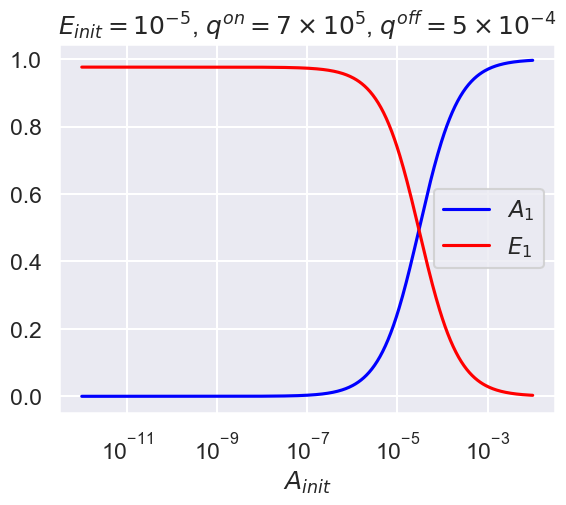

In [380]:
sns.set_theme()
sns.set_context('talk')

plt.plot(A0s, A1s, label = r'$A_1$', c='blue')
plt.plot(A0s, E1s,  label = r'$E_1$', c='red')
plt.xscale('log')
plt.title(r'$E_{init}=10^{-5}$, $q^{on}=7 \times 10^5$, $q^{off} = 5 \times 10^{-4}$')
plt.legend(loc='best')
plt.xlabel(r'$A_{init}$')
plt.show()

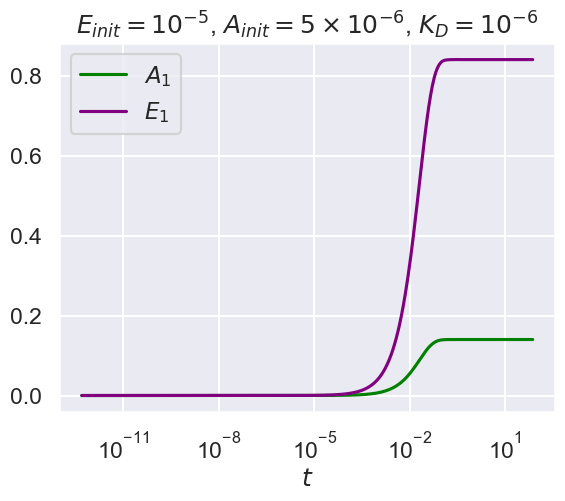

In [381]:
Ainit = 5e-6
z = solve_ivp(nondimensional_model, t_span, z0, method='BDF', t_eval=t_eval, args=(Ainit, phi, mu, mu_off, Einit))
A1 = z.y[0]
E1  = z.y[1]
plt.title(r'$E_{init}=10^{-5}$, $A_{init}=5 \times 10^{-6}$, $K_D = 10^{-6}$')
plt.plot(t_eval, A1, label=r'$A_1$', c='green')
plt.plot(t_eval, E1, label=r'$E_1$', c='purple')
plt.xscale('log')
plt.xlabel(r'$t$')
plt.legend(loc='best')
plt.show()

In [382]:
def steady_state_A1(x, phi, delta, beta, mu_off, mu):
    
    f3 = -1/phi -delta*beta
    f2 = (delta-1)*(beta**2) + (delta-1 - (1/phi)*(1+delta + (mu_off/mu)))*beta -(mu_off/mu)*(1/(phi**2))
    f1 = (1+beta+(1/phi))*(delta*(beta**2)-beta+(mu_off*beta/(mu*phi))) +(beta**2)*(1-2*delta) + beta -delta*(beta**3)
    f0 = -mu_off*(beta**2)/(mu*phi)

    return f3*(x**3) + f2*(x**2) + f1*x + f0


In [383]:
A0s = np.geomspace(1e-12, 1e-2, 500)
Ast = np.zeros_like(A0s)
E1s = np.zeros_like(A0s)

for i, Ainit in enumerate(A0s):

    Atot = Ainit*sigma
    beta = Atot/rtot
    delta = Einit/Ainit
    Ast[i] = fsolve(steady_state_A1, [1e-3], args=(phi, delta, beta, mu_off, mu))

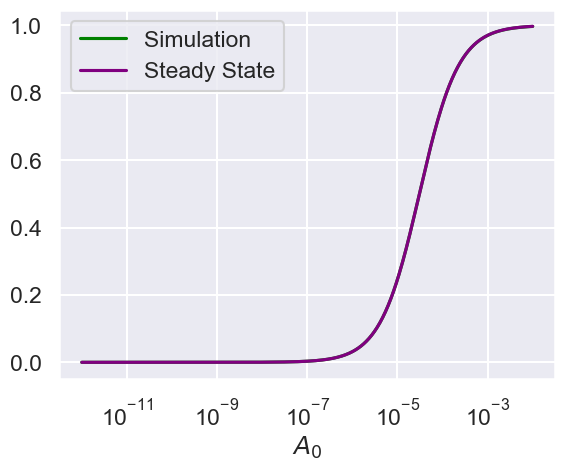

In [384]:
plt.plot(A0s, A1s,  label = r'Simulation', c='green')
plt.plot(A0s, Ast,  label = r'Steady State', c='purple')
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel(r'$A_{0}$')
plt.show()

In [385]:
E0s = np.geomspace(1e-10, 1e-4, 10)
A0s = np.geomspace(1e-10, 1e-2, 10)
qons = [1e-3, 1e-4, 1e-5]
EC50_result = []

for qoff in qons:

    rtot = 2.2e5
    qon = 6.5e3
    qoff = qoff
    qon_e = 6.5e3
    qoff_e = 4.7e-3

    qon = qon/sigma
    qon_e = qon_e/sigma

    phi = qon*rtot/qoff
    mu = qon_e/qon
    mu_off = qoff_e/qoff

    Ec50s = np.zeros_like(E0s)
    for i, Einit in enumerate(E0s):
        A1s = np.zeros_like(A0s)
        for j, Ainit in enumerate(A0s):
            Atot = Ainit*sigma
            beta = Atot/rtot
            delta = Einit/Ainit
            A1s[j] = fsolve(steady_state_A1, [1e-3], args=(phi, delta, beta, mu_off, mu))  

        index = EC50_finder(A1s, 0.5*np.max(A1s))
        Ec50s[i] = A0s[index] 
    EC50_result.append(Ec50s)


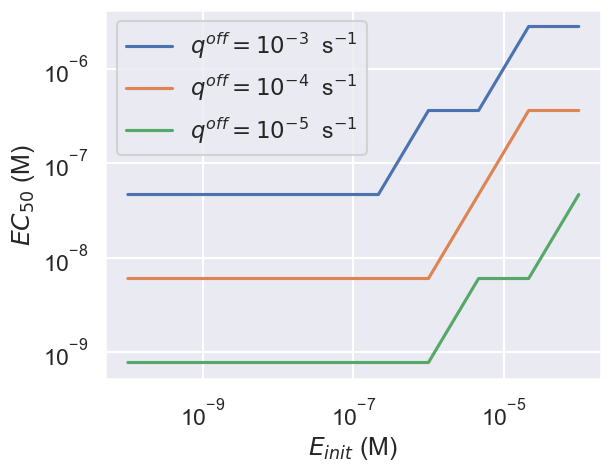

In [386]:
labels = [r'$q^{off}=10^{-3}$  s$^{-1}$', r'$q^{off}=10^{-4}$  s$^{-1}$',r'$q^{off}=10^{-5}$  s$^{-1}$']
for i, label in enumerate(labels):
    plt.plot(E0s, EC50_result[i], label=label)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.ylabel(r'$EC_{50}$ (M)')
plt.xlabel(r'$E_{init}$ (M)')
plt.show()

In [387]:
E0s = np.geomspace(1e-10, 1e-4, 50)
qons = np.flip(np.geomspace(1e3, 1e5, 50))
qoffs = np.flip(np.geomspace(1e-3, 1e-4, 50))
A0s = np.geomspace(1e-12, 1e-2, 150)
Kds = qoffs/qons
Y = np.zeros((len(qoffs), len(E0s)))

for k, qoff in enumerate(qoffs):

    rtot = 2.2e5
    qon = qons[k]
    qoff = qoff
    qon_e = 6.5e3
    qoff_e = 4.7e-3

    qon = qon/sigma
    qon_e = qon_e/sigma

    phi = qon*rtot/qoff
    mu = qon_e/qon
    mu_off = qoff_e/qoff

    for i, Einit in enumerate(E0s):
        A1s = np.zeros_like(A0s)
        for j, Ainit in enumerate(A0s):
            Atot = Ainit*sigma
            beta = Atot/rtot
            delta = Einit/Ainit
            A1s[j] = fsolve(steady_state_A1, [1e-3], args=(phi, delta, beta, mu_off, mu))  

        index = EC50_finder(A1s, 0.5*np.max(A1s))
        Ec50 = A0s[index] 
        Y[k, i] =  Ec50


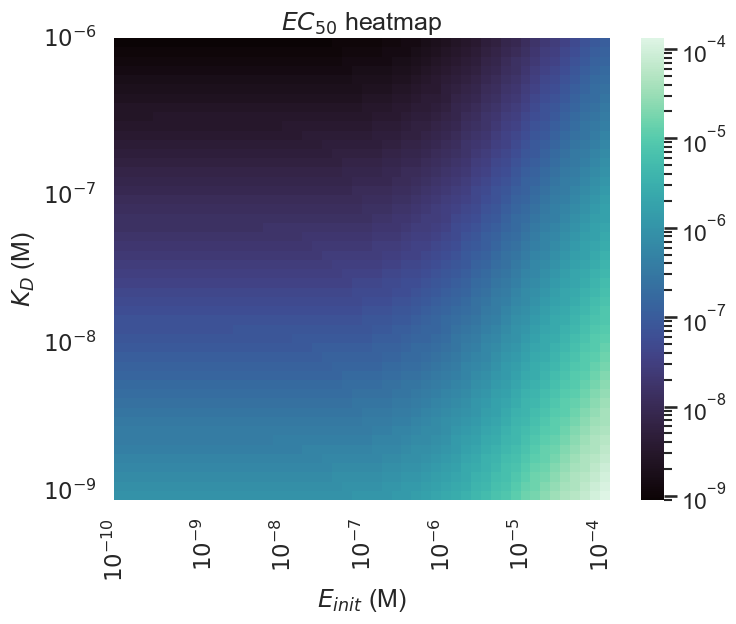

In [388]:
log_norm = LogNorm(vmin=Y.min().min(), vmax=Y.max().max())
fig, ax = plt.subplots(figsize=(8, 6))
line = sns.heatmap(Y, xticklabels=True, yticklabels=True, ax=ax, norm=log_norm, cmap='mako') 
ax.set_xticks([0, 9, 17, 25, 33, 41, 49])
ax.set_yticks([0, 17, 33, 49])
ax.set_yticklabels([r'$10^{-6}$', r'$10^{-7}$',r'$10^{-8}$', r'$10^{-9}$'])
ax.set_xticklabels([r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$'])
ax.set_xlabel(r'$E_{init}$' + ' (M)')
ax.set_ylabel(r'$K_D$ (M)')
ax.set_title(r'$EC_{50}$ heatmap')
plt.show()

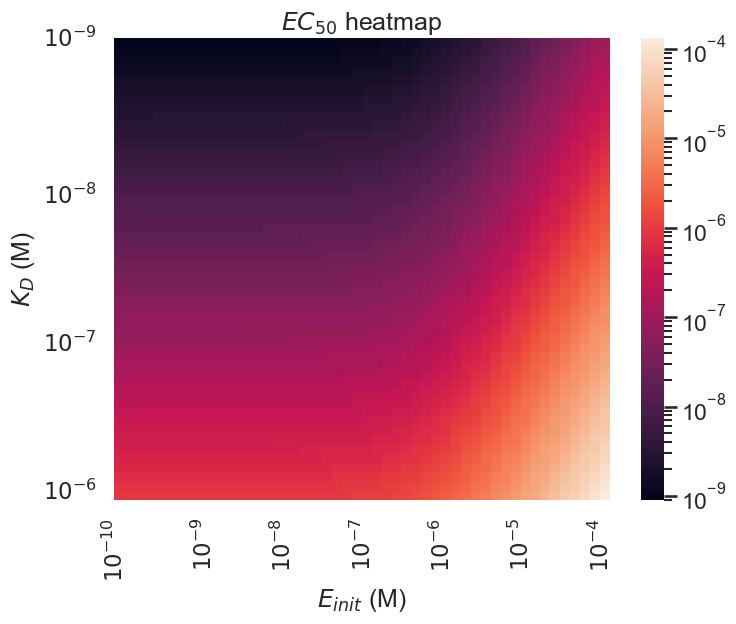

In [389]:
log_norm = LogNorm(vmin=Y.min().min(), vmax=Y.max().max())
fig, ax = plt.subplots(figsize=(8, 6))
line = sns.heatmap(Y, xticklabels=True, yticklabels=True, ax=ax, norm=log_norm) 
ax.set_xticks([0, 9, 17, 25, 33, 41, 49])
ax.set_yticks([0, 17, 33, 49])
ax.set_yticklabels([r'$10^{-9}$', r'$10^{-8}$',r'$10^{-7}$', r'$10^{-6}$'])
ax.set_xticklabels([r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$'])
ax.set_xlabel(r'$E_{init}$' + ' (M)')
ax.set_ylabel(r'$K_D$ (M)')
ax.set_title(r'$EC_{50}$ heatmap')
plt.show()